In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0,12.0]
%matplotlib inline

from keras import backend as K
from keras import utils
from keras.utils.training_utils import multi_gpu_model
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import xception
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from coremdlr.utils import facies_utils, models_utils

Using TensorFlow backend.


In [2]:
DATA_DIR = '/home/administrator/Dropbox/core_data/facies/Columns/'
SAVE_DIR = '/home/administrator/Dropbox/core_data/saved_models/xception/'

In [3]:
img = np.load(DATA_DIR+'CoreLab_FULL_image.npy')
labels = np.load(DATA_DIR+'CoreLab_FULL_facies.npy')
img.shape, labels.shape

((607450, 420, 3), (607450,))

In [4]:
n_classes = 9
metrics=['accuracy']

# trying 380 width
X, y = facies_utils.make_labeled_frames(img[:,20:400], labels, 96)

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=27,
                                                  stratify=y)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)

Making  6327  patches...
Label counts =  [(1, 418), (2, 322), (3, 285), (4, 2150), (5, 2057), (6, 250), (7, 664), (8, 90), (9, 91)]


In [5]:
y_train = utils.to_categorical(y_train, n_classes)
y_val = utils.to_categorical(y_val, n_classes)

print('Training label counts: ', np.sum(y_train, axis=0))
print('Validate label counts: ', np.sum(y_val, axis=0))

Training label counts:  [ 334.  258.  228. 1720. 1645.  200.  531.   72.   73.]
Validate label counts:  [ 84.  64.  57. 430. 412.  50. 133.  18.  18.]


In [6]:
train_gen = ImageDataGenerator(width_shift_range=0.2,
                               height_shift_range=0.05,
                               shear_range=-5.0,
                               zoom_range=0.05,
                               fill_mode='constant', cval=0.0,
                               horizontal_flip=True)
val_gen = ImageDataGenerator()

train_gen.fit(X_train)
val_gen.fit(X_val)

In [7]:
xception_base = xception.Xception(include_top=False, weights=None, input_shape=(96,380,3))
xception_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 380, 3)   0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 47, 189, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 47, 189, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 47, 189, 32)  0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [8]:
x = xception_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=xception_base.input, outputs=predictions)

model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=metrics)

print("CURRENT TRAINABLE LAYERS:")
models_utils.print_layers(model, only_trainable=True)

CURRENT TRAINABLE LAYERS:
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d_1 True
13 block2_pool True
14 batch_normalization_1 True
15 add_1 True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_2 True
23 block3_pool True
24 batch_normalization_2 True
25 add_2 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_3 True
33 block4_pool True
34 batch_normalization_3 True
35 add_3 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn T

In [ ]:
epochs = 500
batch_size = 32 
early_stop = EarlyStopping(monitor='val_loss', patience=50)

train_flow = train_gen.flow(X_train, y_train, batch_size=batch_size)
val_flow = val_gen.flow(X_val, y_val, batch_size=batch_size)

In [ ]:
history_1 = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train)/batch_size,
                    class_weight = class_weights,
                    validation_data=val_flow,
                    validation_steps=len(X_val)/batch_size,
                    callbacks=[early_stop], verbose=1, epochs=epochs)

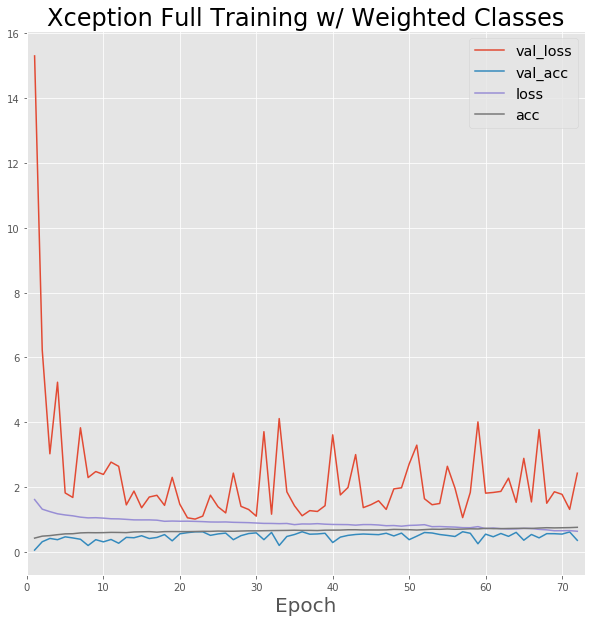

In [16]:
plt.show(models_utils.make_training_fig(history_1.history,
                      title="Xception Full Training w/ Weighted Classes"))

In [12]:
with open('./training_logs/Xception_randomInit_weighted', 'wb') as hist_pickle:
        pickle.dump(history_1.history, hist_pickle)
        
models_utils.save_keras_model(model, SAVE_DIR+'Xception_randomInit_weighted')

In [13]:
y_hat = model.predict_generator(val_gen.flow(X_val))
y_hat = np.argmax(y_hat, axis=1)

y_true = np.argmax(y_val, axis=1)

In [14]:
facies_names = ['argilaceous siltstone', 'fossiliferous argilaceous siltstone',
     'siliceous mudstone', 'argilaceous siliceous mudstone', 'calcareous siliceous mudstone',
     'wackestone', 'packstone - grainstone', 'rudstone', 'dolomitic packstone']

cnf_matrix = confusion_matrix(y_true+1, y_hat+1)

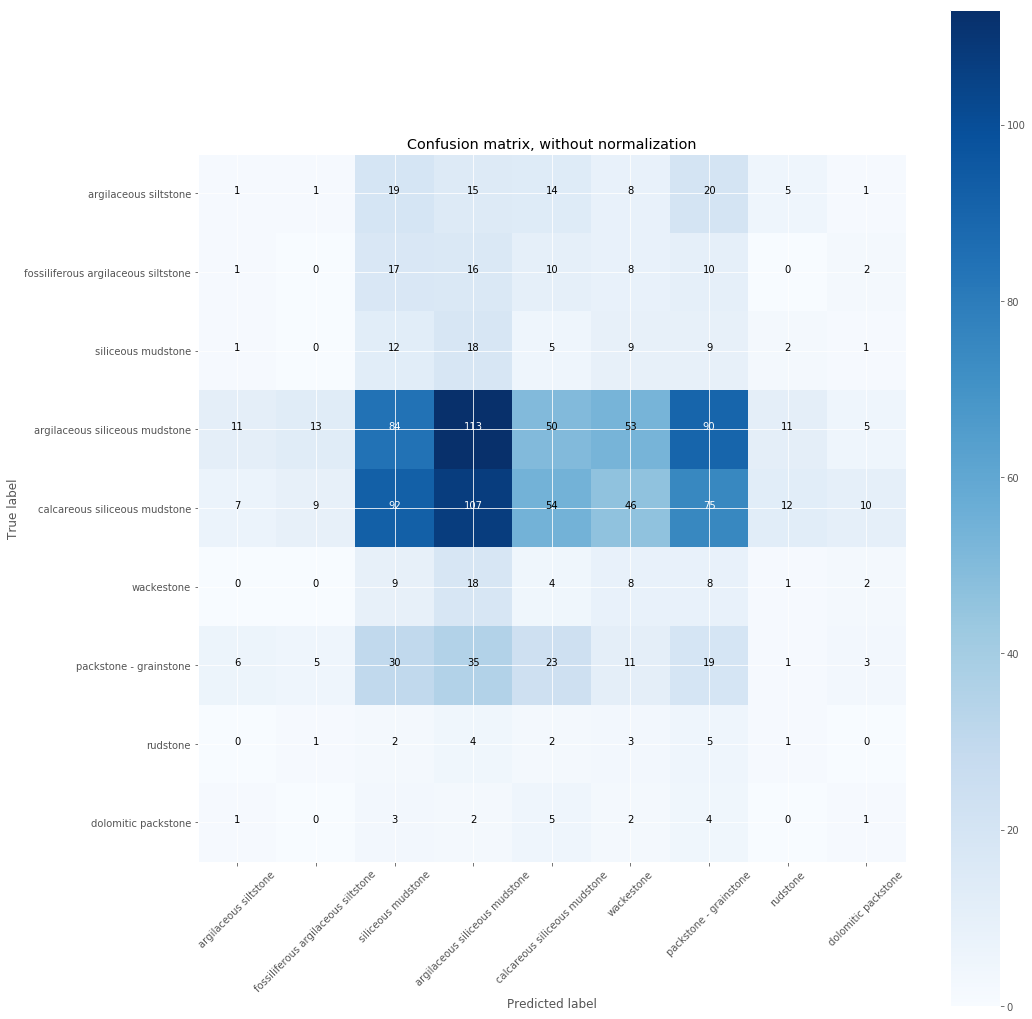

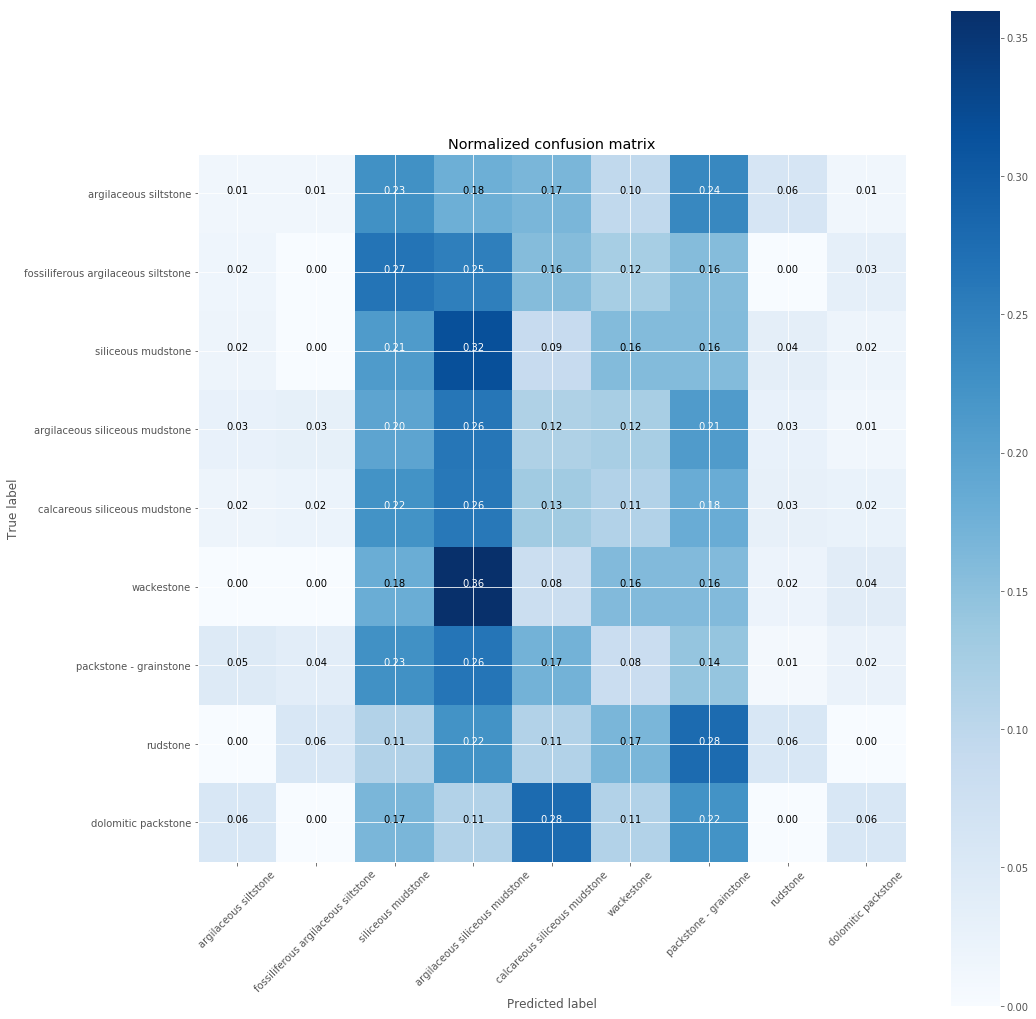

In [15]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
models_utils.make_confusion_fig(cnf_matrix, classes=facies_names,
                      title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
models_utils.make_confusion_fig(cnf_matrix, classes=facies_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [17]:
# Print Validation Accuracy
sum(np.equal(y_true, y_hat)) / y_hat.size

0.165086887835703